In [ ]:
!nvidia-smi

Mon Sep 13 01:44:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls drive/MyDrive/

 Ellen@              melting_point/      'UCL Bootcamp master Document.gdoc'
'Meeting Minutes'/   MSc_Project_Ellen/   UCL_CW/


In [ ]:
cd drive/MyDrive/MSc_Project_Ellen/

/content/drive/MyDrive/MSc_Project_Ellen


## "globals"

In [ ]:
# order of atoms in a molecule
_ORDER_ = {"methane":["C","H","H","H","H"], 
         "ethane":["C","C","H","H","H","H","H","H"], 
         "propane":["C","C","H","H","H","H","H","C","H","H","H"], 
         "butane":["C","C","H","H","H","H","H","C","H","C","H","H","H","H"], 
         "isobutane":["C","C","C","H","C","H","H","H","H","H","H","H","H","H"],
         "water":["O","H","H"],
         "benzene":["C","C","C","C","C","C","H","H","H","H","H","H"],
         "toluene":["C","C","C","C","C","C","C","H","H","H","H","H","H","H","H"],
         "malonaldehyde":["C","C","C","O","O","H","H","H","H"],
         "ethanol":["C","C","O","H","H","H","H","H","H"],
         "ethylene":["C","C","H","H","H","H"],
         "acetylene":["C","C","H","H"],
         "propene":["C","C","C","H","H","H","H","H","H"],
         "methanol":["C","O","H","H","H","H"],
         "ethanal":["C","C","O","H","H","H","H"],
         "dimethylether":["C","O","C","H","H","H","H","H","H"]
         }

In [ ]:
# n and l for each element of a particular basis
_BASIS_ = {"ccpvtz":{"H":{"n":3, "l":3},
                     "C":{"n":4, "l":4},
                     "O":{"n":4, "l":4}}}

## Symmetrizer

Dick called this trace the symmetriser  $d_{nl} = \sum_m c_{nlm}^2$


In [ ]:
def trace_sym(c:np.ndarray, m:str, basis:str, padding={"H":10,"C":7,"O":2}):
    """
    trace symmetriser d_{nl} = \sum_m c_{nlm}^2
    Input:
    c     - flattened unsymmetrised projectors
    m     - molecule name
    basis - the basis of which the density is projected onto
    Output:
    d     - symmetrised and padded descriptors (H, C and O padded to 10, 4 and 2, respectively)
    """
    d = {"H":[], "C":[], "O":[]}
    idx = 0
    #symmetrize
    for atom in _ORDER_[m]:
        n_max = _BASIS_[basis][atom]["n"]
        l_max = _BASIS_[basis][atom]["l"]
        for n in range(n_max):
            for l in range(l_max):
                d[atom].append(np.linalg.norm(c[idx:idx+(2*l+1)])**2)
                idx += 2*l+1
    #padding
    target_H_len = padding["H"]*_BASIS_[basis]["H"]["n"]*_BASIS_[basis]["H"]["l"]
    target_C_len = padding["C"]*_BASIS_[basis]["C"]["n"]*_BASIS_[basis]["C"]["l"]
    target_O_len = padding["O"]*_BASIS_[basis]["O"]["n"]*_BASIS_[basis]["O"]["l"]

    if len(d["H"]) < target_H_len:
        d["H"] += [0] * (target_H_len - len(d["H"]))
    if len(d["C"]) < target_C_len:
        d["C"] += [0] * (target_C_len - len(d["C"]))
    if len(d["O"]) < target_H_len:
        d["O"] += [0] * (target_O_len - len(d["O"]))

    return d["H"]+d["C"]+d["O"]


In [ ]:
def make_combined_data(ms:list):
    """[0:-1] columns are the descriptors and the -1 column will be the target correction energy in eV"""
    output_list = []
    for name in ms:
        stacked_descirptors = []
        cs = np.load(f"neural_xc_playground/tmp_{name}/ccpvdz2ccpvtz_p/p.npy")
        for i in range(len(cs)):
            stacked_descirptors.append(trace_sym(cs[i], name.split('_')[0], "ccpvtz"))
        stacked_ds = np.array(stacked_descirptors)
        pbe_energy = np.loadtxt(f"Dataset/energy/{name}_pbe.txt")
        cc_energy = np.loadtxt(f"Dataset/energy/{name}_cc.txt")
        delta_e = (cc_energy - pbe_energy) *27.2114
        output_list.append(np.hstack((stacked_ds, delta_e.reshape(-1,1))))
    output = output_list[0]
    if len(output_list) > 1:
        for tmp in output_list[1:]:
            output = np.vstack((output, tmp))
    f_n = ms[0].split('_')[0]
    np.save(f"dataset_BP_clean/{f_n}_labelled_ds_10_7_2.npy", output)
    return 

In [ ]:
make_combined_data(["ethanol_train", "ethanol_test"])

In [ ]:
# with open("Dataset/propene.xyz") as f:
#     lines = f.readlines()
# for line in lines:
#     if line.startswith("-"):
#         print(float(line)/27.2114)

In [ ]:
ls -rtl dataset_BP_clean/

total 27738
-rw------- 1 root root 3760128 Sep  6 19:25 'ethanol_labelled_ds_10_7_2 (1).npy'
-rw------- 1 root root 1880128 Sep  6 19:27  water_labelled_ds_10_7_2.npy
-rw------- 1 root root 2822008 Sep  6 19:27  toluene_labelled_ds_10_7_2.npy
-rw------- 1 root root  188128 Sep  6 19:27  propene_labelled_ds_10_7_2.npy
-rw------- 1 root root 1880128 Sep  6 19:27  propane_labelled_ds_10_7_2.npy
-rw------- 1 root root 1880128 Sep  6 19:28  methanol_labelled_ds_10_7_2.npy
-rw------- 1 root root  190008 Sep  6 19:28  methane_labelled_ds_10_7_2.npy
-rw------- 1 root root 2820128 Sep  6 19:28  malonaldehyde_labelled_ds_10_7_2.npy
-rw------- 1 root root  190008 Sep  6 19:29  isobutane_labelled_ds_10_7_2.npy
-rw------- 1 root root  188128 Sep  6 19:29  ethylene_labelled_ds_10_7_2.npy
-rw------- 1 root root 1880128 Sep  6 19:29  ethane_labelled_ds_10_7_2.npy
-rw------- 1 root root 1880128 Sep  6 19:29  ethanal_labelled_ds_10_7_2.npy
-rw------- 1 root root 1880128 Sep  6 19:29  dimethylether_label

In [ ]:
total = np.zeros((0,))
for name in _ORDER_.keys():
    data = np.load(f"dataset_BP_clean/{name}_labelled_ds_10_7_2.npy")
    delta_E = data[:,-1]
    normalised_mean = np.mean(delta_E-np.min(delta_E))
    total = np.hstack((total,delta_E))
    print(f"{name}: mean={np.mean(delta_E):.4f}, std={np.std(delta_E):.4f}, std/mean={np.std(delta_E)/np.mean(delta_E):.4f}, n. mean={normalised_mean:.4f}")
print(f"total: mean={np.mean(total):.4f}, std={np.std(total):.4f}, std/mean={np.std(total)/np.mean(total):.4f}, n. mean={np.mean(total-np.min(total)):.4f}  ")

methane: mean=0.1543, std=0.0338, std/mean=0.2188, n. mean=0.0827
ethane: mean=0.6845, std=0.0429, std/mean=0.0627, n. mean=0.1517
propane: mean=1.1898, std=0.0505, std/mean=0.0425, n. mean=0.1517
butane: mean=1.6935, std=0.0541, std/mean=0.0319, n. mean=0.1561
isobutane: mean=1.6603, std=0.0519, std/mean=0.0313, n. mean=0.1328
water: mean=0.0667, std=0.0315, std/mean=0.4719, n. mean=0.0836
benzene: mean=13.8899, std=0.0176, std/mean=0.0013, n. mean=0.0550
toluene: mean=16.1743, std=0.0291, std/mean=0.0018, n. mean=0.0904
malonaldehyde: mean=14.9937, std=0.0362, std/mean=0.0024, n. mean=0.1009
ethanol: mean=2.8957, std=0.0822, std/mean=0.0284, n. mean=0.2913
ethylene: mean=0.8969, std=0.0427, std/mean=0.0476, n. mean=0.0693
acetylene: mean=0.9601, std=0.0304, std/mean=0.0317, n. mean=0.0608
propene: mean=1.4593, std=0.0283, std/mean=0.0194, n. mean=0.0618
methanol: mean=0.3316, std=0.0192, std/mean=0.0579, n. mean=0.0564
ethanal: mean=6.1926, std=0.0153, std/mean=0.0025, n. mean=0.0426

In [ ]:
def split_data(ms:list, ratio=0.8):
    "slpit data randomly into training and testing set, ratio is the % of training data"
    np.random.seed(0)
    n_cols = np.load(f"dataset_BP_clean/{ms[0]}_labelled_ds_10_7_2.npy").shape[1]
    train = np.zeros((1, n_cols))
    test = np.zeros((1, n_cols))
    for name in ms:
        data = np.load(f"dataset_BP_clean/{name}_labelled_ds_10_7_2.npy")
        np.random.shuffle(data)
        train = np.vstack((train, data[:int(ratio*data.shape[0])]))
        test = np.vstack((test, data[int(ratio*data.shape[0]):]))
    return train[1:], test[1:]


## Behler Parrinello Neural Network

In [ ]:
class BPNN(nn.Module):
    def __init__(self, layers=[64,16,4,1], acti=nn.Tanh(), basis:str="ccpvtz", padding={"H":10,"C":7,"O":2}):
        ''' 
        Keywords
        layers: last layer of each atomic nn should have 1 node only
        acti: please use a activation function that ranges from negative to positive and acti(0)=0, such as elu, gelu, tanh
        '''
        super(BPNN, self).__init__()

        self.padding = padding

        self.d_H_size = _BASIS_[basis]["H"]["n"]*_BASIS_[basis]["H"]["l"]
        self.d_C_size = _BASIS_[basis]["C"]["n"]*_BASIS_[basis]["C"]["l"]
        self.d_O_size = _BASIS_[basis]["O"]["n"]*_BASIS_[basis]["O"]["l"]

        H_layers = [nn.Linear(self.d_H_size, layers[0], bias=False), acti]
        C_layers = [nn.Linear(self.d_C_size, layers[0], bias=False), acti]
        O_layers = [nn.Linear(self.d_O_size, layers[0], bias=False), acti]

        for i, o in zip(layers[:-1], layers[1:]):
            H_layers += [nn.Linear(i, o, bias=False), acti]
            C_layers += [nn.Linear(i, o, bias=False), acti]
            O_layers += [nn.Linear(i, o, bias=False), acti]
        ## remove the last activation layer
        H_layers = H_layers[:-1]
        C_layers = C_layers[:-1]
        O_layers = O_layers[:-1]

        self.nn_H = nn.Sequential(*H_layers)
        self.nn_C = nn.Sequential(*C_layers)
        self.nn_O = nn.Sequential(*O_layers)
    
    def forward(self, X):
        """
        The shape of X should be (batch_size, self.d_H_size*10 + self.d_C_size*4 + self.d_O_size*2)
        i.e. we are assuming a maximum of 10 H, 4 C and 2 O in a molecule 
        """
        d_H = X[:, 0:self.d_H_size*self.padding["H"]].view(-1, self.padding["H"], self.d_H_size)
        d_C = X[:, self.d_H_size*self.padding["H"]:self.d_H_size*self.padding["H"] + self.d_C_size*self.padding["C"]].view(-1, self.padding["C"], self.d_C_size)
        d_O = X[:, -self.padding["O"]*self.d_O_size:].view(-1, self.padding["O"], self.d_O_size)

        H_out = torch.squeeze(self.nn_H(d_H)).sum(axis=-1)
        C_out = torch.squeeze(self.nn_C(d_C)).sum(axis=-1)
        O_out = torch.squeeze(self.nn_O(d_O)).sum(axis=-1)
        return H_out + C_out + O_out

In [ ]:
# class BPNN(nn.Module):
#     def __init__(self, basis:str="ccpvtz", padding={"H":14,"C":6,"O":2}):
#         super(BPNN, self).__init__()

#         self.padding = padding

#         self.d_H_size = _BASIS_[basis]["H"]["n"]*_BASIS_[basis]["H"]["l"]
#         self.d_C_size = _BASIS_[basis]["C"]["n"]*_BASIS_[basis]["C"]["l"]
#         self.d_O_size = _BASIS_[basis]["O"]["n"]*_BASIS_[basis]["O"]["l"]

#         self.nn_H = nn.Sequential(nn.Linear(self.d_H_size, 64, bias=False), nn.GELU(), nn.Linear(64, 128, bias=False), nn.GELU(), nn.Linear(128, 1, bias=False))
#         self.nn_C = nn.Sequential(nn.Linear(self.d_C_size, 64, bias=False), nn.GELU(), nn.Linear(64, 128, bias=False), nn.GELU(), nn.Linear(128, 1, bias=False))
#         self.nn_O = nn.Sequential(nn.Linear(self.d_O_size, 64, bias=False), nn.GELU(), nn.Linear(64, 128, bias=False), nn.GELU(), nn.Linear(128, 1, bias=False))
    
#     def forward(self, X):
#         """
#         The shape of X should be (batch_size, self.d_H_size*10 + self.d_C_size*4 + self.d_O_size*2)
#         i.e. we are assuming a maximum of 10 H, 4 C and 2 O in a molecule 
#         """
        
#         d_H = X[:, 0:self.d_H_size*self.padding["H"]].view(-1, self.padding["H"], self.d_H_size)
#         d_C = X[:, self.d_H_size*self.padding["H"]:self.d_H_size*self.padding["H"] + self.d_C_size*self.padding["C"]].view(-1, self.padding["C"], self.d_C_size)
#         d_O = X[:, -self.padding["O"]*self.d_O_size:].view(-1, self.padding["O"], self.d_O_size)

#         H_out = torch.squeeze(self.nn_H(d_H)).sum(axis=-1)
#         C_out = torch.squeeze(self.nn_C(d_C)).sum(axis=-1)
#         O_out = torch.squeeze(self.nn_O(d_O)).sum(axis=-1)
#         return H_out + C_out + O_out

In [ ]:
def train_model(m, xTr, yTr, xVa, yVa, learning_rate=0.0005 ,max_iter=50000, model_name="best_model.pt"):
    loss_fn = torch.nn.MSELoss() # minimise mean squared error during training
    mae = torch.nn.L1Loss()      # plot mean absolute error for comparison, didn't minimise this as not sure about if we want sparsity or not
    optimizer = torch.optim.Adam(m.parameters(),lr=learning_rate)
    loss_train_history = []
    loss_valid_history = []
    best_valid_loss = 100

    for t in range(1, max_iter+1):
        #forward
        y_pred = m(xTr)
        loss = loss_fn(y_pred, yTr)
        #backward
        optimizer.zero_grad()
        loss.backward() #compute gradient of loss with respect to weights
        optimizer.step() #update weights

        #print
        if t % 1000 == 0:
            yTr_pred = m(xTr)
            yVa_pred = m(xVa)
            mae_loss_train = mae(yTr_pred, yTr)
            mae_loss_valid = mae(yVa_pred, yVa)
            loss_train_history.append([t, mae_loss_train.item()])
            loss_valid_history.append([t, mae_loss_valid.item()])
            n_within_1kcal = torch.sum(torch.abs(yVa_pred-yVa)<0.043)
            print(f"epoch {t}, mae_train={mae_loss_train.item()}, mae_valid={mae_loss_valid.item()}, % valid chemical accuracy={n_within_1kcal/len(yVa)}")
            if mae_loss_valid.item() < best_valid_loss:
                best_valid_loss = mae_loss_valid.item()
                torch.save(m, f"Models_BP/{model_name}")
        if len(loss_valid_history) > 3 and np.all(np.greater(loss_valid_history[-3:], best_valid_loss)):
            break
    return m, (loss_train_history, loss_valid_history)


In [ ]:
def eavl_model(m:nn.Module, Te:np.ndarray):
    xTe = torch.tensor(Te[:,:-1]).to("cuda")
    yTe = torch.tensor(Te[:,-1]).to("cuda")
    with torch.no_grad():
        yTe_pred = m(xTe)
    return yTe.to("cpu").detach().numpy(), yTe_pred.to("cpu").detach().numpy()

In [ ]:
def plot_loss(history):
    loss_train, loss_valid = history
    loss_train = np.array(loss_train)
    loss_valid = np.array(loss_valid)
    plt.plot(loss_train[:,0], loss_train[:,1],'-', label="Train")
    plt.plot(loss_valid[:,0], loss_valid[:,1],'-', label="Test")
    plt.xlabel("epochs")
    plt.ylabel("MAE (eV)")
    plt.legend()
    plt.show()


In [ ]:
for i in _ORDER_.keys():
    data = np.load(f"dataset_BP_clean/{i}_labelled_ds_10_7_2.npy")
    print(i, data.shape)

methane (101, 235)
ethane (1000, 235)
propane (1000, 235)
butane (101, 235)
isobutane (101, 235)
water (1000, 235)
benzene (1500, 235)
toluene (1501, 235)
malonaldehyde (1500, 235)
ethanol (2000, 235)
ethylene (100, 235)
acetylene (100, 235)
propene (100, 235)
methanol (1000, 235)
ethanal (1000, 235)
dimethylether (1000, 235)


## cross validation

In [ ]:
def cross_validation(data_in:np.ndarray, k:int=2):
    """k-fold cross validation"""
    np.random.seed(0)
    np.random.shuffle(data_in)
    best_nn_struct, best_l_rate, best_non_linear = None, None, None
    best_loss = 100
    for nn_struct in [[16,1], [16,4,1],[64,16,4,1], [128,64,16,4,1]]:
        for l_rate in [0.0005]:
            for non_linear in [nn.GELU(), nn.Tanh()]:
                min_valid_loss_list = []
                data = deepcopy(data_in)
                n_samples = data.shape[0]
                valid_size = int(n_samples/k)
                for i in range(k):
                    model = BPNN(layers=nn_struct, acti=non_linear).double()
                    model.to("cuda")
                    xTrain = torch.tensor(data[valid_size:, :-1]).to("cuda")
                    yTrain = torch.tensor(data[valid_size:, -1]).to("cuda")
                    xValid = torch.tensor(data[:valid_size, :-1]).to("cuda")
                    yValid = torch.tensor(data[:valid_size, -1]).to("cuda")
                    model, loss_history = train_model(model, xTrain, yTrain, xValid, yValid, learning_rate=l_rate, max_iter=100000)
                    loss_train, loss_valid = loss_history
                    min_valid_loss_list.append(np.min(loss_valid))
                    data = np.roll(data, valid_size,axis=0)
                mean_valid_loss = np.mean(min_valid_loss_list)
                if mean_valid_loss < best_loss:
                    best_loss = mean_valid_loss 
                    best_nn_struct, best_l_rate, best_non_linear = nn_struct, l_rate, non_linear
                with open("BP_CV_log.txt","a") as f:
                    f.write(f"{nn_struct}, {l_rate}, {non_linear}, {mean_valid_loss}\n")
                print(f"!!! {nn_struct}, {l_rate}, {non_linear}, {mean_valid_loss} !!!")
    return best_loss, best_nn_struct, best_l_rate, best_non_linear

In [ ]:
Train_1, Test_1 = split_data(list(_ORDER_.keys()))

### old trial

In [ ]:
cross_validation(Train_1)

epoch 1000, mae_train=0.6356518916601949, mae_valid=0.6344312128582978
epoch 2000, mae_train=0.5456918386286489, mae_valid=0.5452071280041765
epoch 3000, mae_train=0.28697462304695837, mae_valid=0.29169333610969883
epoch 4000, mae_train=0.19882712000268876, mae_valid=0.20288545996894597
epoch 5000, mae_train=0.1575760505857328, mae_valid=0.15897903451209108
epoch 6000, mae_train=0.13325296821677995, mae_valid=0.13341594794611544
epoch 7000, mae_train=0.11767871194413869, mae_valid=0.11717703620079921
epoch 8000, mae_train=0.10802157471696024, mae_valid=0.10737399497865786
epoch 9000, mae_train=0.10209701130772544, mae_valid=0.10154928432783698
epoch 10000, mae_train=0.09803378708846112, mae_valid=0.09768064440949062
epoch 11000, mae_train=0.09488588298943862, mae_valid=0.0947043203420161
epoch 12000, mae_train=0.09229083786767606, mae_valid=0.09225054423639616
epoch 13000, mae_train=0.08988289413965511, mae_valid=0.08999175724062002
epoch 14000, mae_train=0.08759443752878286, mae_valid

KeyboardInterrupt: ignored

### cv run

In [ ]:
cross_validation(Train_1)

epoch 1000, mae_train=0.6561086886433736, mae_valid=0.6475356267168034
epoch 2000, mae_train=0.577716029015173, mae_valid=0.5674041023286123
epoch 3000, mae_train=0.48840877914804115, mae_valid=0.4756812349974982
epoch 4000, mae_train=0.3821375325166884, mae_valid=0.3723859475383665
epoch 5000, mae_train=0.28057697197369774, mae_valid=0.2729225800828042
epoch 6000, mae_train=0.2015036172265277, mae_valid=0.1972937308079242
epoch 7000, mae_train=0.1646213211900043, mae_valid=0.16203172253964418
epoch 8000, mae_train=0.14861446700781034, mae_valid=0.14591244227034428
epoch 9000, mae_train=0.1399351736248677, mae_valid=0.13748697662486317
epoch 10000, mae_train=0.13449373869423173, mae_valid=0.13228997411400362
epoch 11000, mae_train=0.1304762400034142, mae_valid=0.12854616320653492
epoch 12000, mae_train=0.12711851966453205, mae_valid=0.12542942246961106
epoch 13000, mae_train=0.12413133077904455, mae_valid=0.12265503592207604
epoch 14000, mae_train=0.12136871075838797, mae_valid=0.12004

(0.0213447547372742, [64, 16, 4, 1], 0.0005, Tanh())

### use the tuned parameters on the whole Train_1 dataset

In [ ]:
model1 = BPNN(layers=[64, 16, 4, 1], acti=nn.Tanh()).double()
model1.to("cuda")
xTrain = torch.tensor(Train_1[:, :-1]).to("cuda")
yTrain = torch.tensor(Train_1[:, -1]).to("cuda")
xValid = torch.tensor(Test_1[:, :-1]).to("cuda")
yValid = torch.tensor(Test_1[:, -1]).to("cuda")
model1, loss_history = train_model(model1, xTrain, yTrain, xValid, yValid, max_iter=200000)

epoch 1000, mae_train=1.6761068152578165, mae_valid=1.69321196672021
epoch 2000, mae_train=1.1007735864138781, mae_valid=1.1185262640465636
epoch 3000, mae_train=0.7658569074727234, mae_valid=0.7725566931084734
epoch 4000, mae_train=0.7225190037447455, mae_valid=0.7262020267257285
epoch 5000, mae_train=0.6466045638679774, mae_valid=0.6496169659484612
epoch 6000, mae_train=0.503090727299062, mae_valid=0.5106967717932447
epoch 7000, mae_train=0.34871789904818995, mae_valid=0.356034960780119
epoch 8000, mae_train=0.3106531409114012, mae_valid=0.3179412306588153
epoch 9000, mae_train=0.2916995460122267, mae_valid=0.29951783748569855
epoch 10000, mae_train=0.272404088588137, mae_valid=0.27992644800958205
epoch 11000, mae_train=0.15910483292403066, mae_valid=0.16423604636609188
epoch 12000, mae_train=0.13187251109812512, mae_valid=0.13528739037989645
epoch 13000, mae_train=0.10718149031946621, mae_valid=0.10986580875279006
epoch 14000, mae_train=0.09481246125179743, mae_valid=0.0969196013363

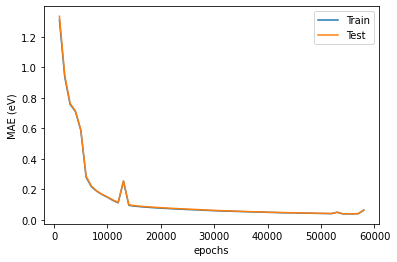

In [ ]:
plot_loss(loss_history)

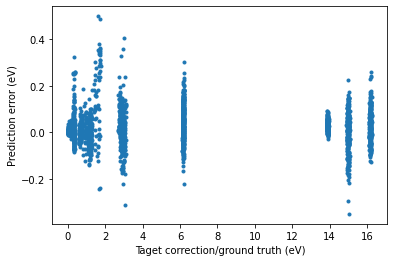

In [ ]:
plt.plot(yValid.cpu().detach().numpy(), model1(xValid).cpu().detach().numpy()-yValid.cpu().detach().numpy(), '.')
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.show()

In [ ]:
np.abs(model1(xValid).cpu().detach().numpy()-yValid.cpu().detach().numpy()).mean()

0.051772931283036804

In [ ]:
(np.abs(model1(xValid).cpu().detach().numpy()-yValid.cpu().detach().numpy()) < 0.05).sum()

1655

In [ ]:
len(yValid)

2624

In [ ]:
1655/2624

0.6307164634146342

## data efficiency

In [ ]:
for name in ["propane","water","benzene", "methanol"]:
    Tr, Te = split_data([name])
    for n in [10,100,800]:
        print(f"!!!{name}_{n}!!!\n")
        xTrain = torch.tensor(Tr[:n, :-1]).to("cuda")
        yTrain = torch.tensor(Tr[:n, -1]).to("cuda")
        xTest = torch.tensor(Te[:200, :-1]).to("cuda")
        yTest = torch.tensor(Te[:200, -1]).to("cuda")
        model_tmp = BPNN().double()
        model_tmp.to("cuda")
        model_tmp, loss_history = train_model(model_tmp, xTrain, yTrain, xTest, yTest, max_iter=100000, model_name=f"{name}_{n}.pt")


!!!propane_10!!!

epoch 1000, mae_train=0.01952927141740468, mae_valid=0.02645529743684305, % valid chemical accuracy=0.8399999737739563
epoch 2000, mae_train=0.008607215983196094, mae_valid=0.011561529913972192, % valid chemical accuracy=1.0
epoch 3000, mae_train=0.006184675473138568, mae_valid=0.0080695803720761, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.00456795116614932, mae_valid=0.006440001698854176, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.0036079976282018533, mae_valid=0.005714279413906151, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.006161092543094227, mae_valid=0.008870120195307769, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.003247092737543511, mae_valid=0.005857048008307906, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.0026670156997372187, mae_valid=0.005386385194615373, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.0025995699147144617, mae_valid=0.005445445407756682, % valid chemical accuracy=1.0
epoch 10000, ma

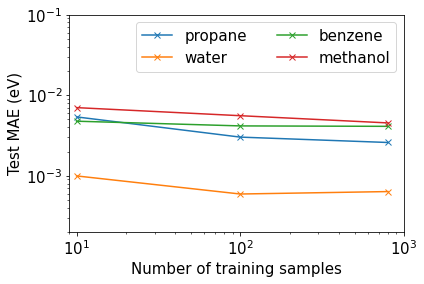

In [ ]:
plt.plot([10,100,800],[0.00538, 0.00302, 0.00259],'x-',label="propane")
plt.plot([10,100,800],[0.000996, 0.000594, 0.000637],'x-',label="water")
plt.plot([10,100,800],[0.00476, 0.00416, 0.00411],'x-',label="benzene")
plt.plot([10,100,800],[0.007015,0.00557, 0.00453],'x-',label="methanol")
plt.xlabel("Number of training samples")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Test MAE (eV)")
plt.ylim([0.0002,0.1])
plt.xlim([9,1e3])
plt.legend(ncol=2, loc="best")
plt.savefig("Plots/BP_efficiency.pdf", bbox_inches='tight')
plt.show()

## all cheng's

In [ ]:
ChengTr, ChengTe = split_data(['methane', 'ethane', 'propane', 'butane', 'isobutane', 'water'])

In [ ]:
xTrain_Cheng = torch.tensor(ChengTr[:, :-1]).to("cuda")
yTrain_Cheng = torch.tensor(ChengTr[:, -1]).to("cuda")
xTest_Cheng = torch.tensor(ChengTe[:, :-1]).to("cuda")
yTest_Cheng = torch.tensor(ChengTe[:, -1]).to("cuda")
model_Cheng = BPNN().double()
model_Cheng.to("cuda")
Model_Cheng, loss_history = train_model(model_Cheng, xTrain_Cheng, 
                                        yTrain_Cheng, xTest_Cheng, yTest_Cheng, max_iter=100000, model_name=f"Cheng_data.pt")

epoch 1000, mae_train=0.02437840247597719, mae_valid=0.02441045988678262, % valid chemical accuracy=0.8205128312110901
epoch 2000, mae_train=0.01674268451732946, mae_valid=0.016778949633706325, % valid chemical accuracy=0.9215686321258545
epoch 3000, mae_train=0.010266780651653285, mae_valid=0.010372346802492976, % valid chemical accuracy=0.9924585223197937
epoch 4000, mae_train=0.008213134801658604, mae_valid=0.008278365064899448, % valid chemical accuracy=0.9984917044639587
epoch 5000, mae_train=0.00718694217842116, mae_valid=0.007164526190930857, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.006405992357754958, mae_valid=0.006348510163401862, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.005664271252462469, mae_valid=0.005593976992865219, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.0050324755047727685, mae_valid=0.004958423505177021, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.00445364967888448, mae_valid=0.004398015901380087, % valid chemical acc

In [ ]:
best_model = torch.load("Models_BP/Cheng_data.pt")
yTe, yTe_pred = eavl_model(best_model, ChengTe)

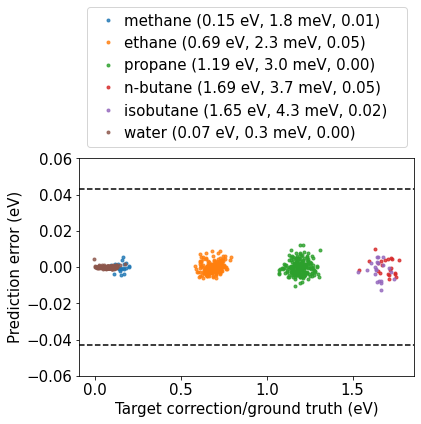

In [ ]:
break_points = [0,21,221,421,442,463,663]
mols = ['methane', 'ethane', 'propane', 'n-butane', 'isobutane', 'water']
for start, end, name in zip(break_points[:-1], break_points[1:], mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.1)
plt.savefig("Plots/Cheng_BP.pdf", bbox_inches='tight')
plt.show()

In [ ]:
yTest_pred_Cheng = model_Cheng(xTest_Cheng).cpu().detach().numpy()

In [ ]:
yTest_Cheng = yTest_Cheng.cpu().detach().numpy()

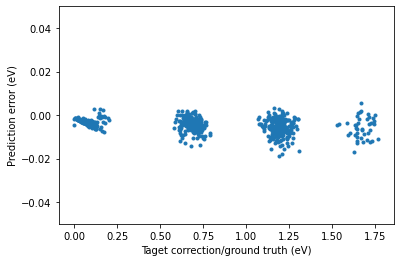

In [ ]:
plt.plot(yTest_Cheng, yTest_pred_Cheng-yTest_Cheng,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/Cheng_BP.pdf")
plt.show()

## Chimela's benzene, toluene, malonaldehyde

In [ ]:
ChimelaTr, ChimelaTe = split_data(['benzene', 'toluene', 'malonaldehyde'])
xTrain_Chimela = torch.tensor(ChimelaTr[:, :-1]).to("cuda")
yTrain_Chimela = torch.tensor(ChimelaTr[:, -1]).to("cuda")
xTest_Chimela = torch.tensor(ChimelaTe[:, :-1]).to("cuda")
yTest_Chimela = torch.tensor(ChimelaTe[:, -1]).to("cuda")
model_Chimela = BPNN().double()
model_Chimela.to("cuda")
Model_Chimela, loss_history = train_model(model_Chimela, xTrain_Chimela, 
                                        yTrain_Chimela, xTest_Chimela, yTest_Chimela, max_iter=100000, model_name=f"Chimela_data.pt")

epoch 1000, mae_train=0.8946905508316768, mae_valid=0.8817913184944873, % valid chemical accuracy=0.0
epoch 2000, mae_train=0.40434293034004537, mae_valid=0.39886912831473037, % valid chemical accuracy=0.07658157497644424
epoch 3000, mae_train=0.3601737563551185, mae_valid=0.3565116272560353, % valid chemical accuracy=0.0621531642973423
epoch 4000, mae_train=0.29901649664356256, mae_valid=0.29524508489925166, % valid chemical accuracy=0.06881242990493774
epoch 5000, mae_train=0.21395128383355497, mae_valid=0.21069014877146794, % valid chemical accuracy=0.08657047897577286
epoch 6000, mae_train=0.11795458480605557, mae_valid=0.1157347667016668, % valid chemical accuracy=0.16759157180786133
epoch 7000, mae_train=0.048809917568111406, mae_valid=0.04839943116368247, % valid chemical accuracy=0.5882353186607361
epoch 8000, mae_train=0.02309078487823346, mae_valid=0.023404120756639932, % valid chemical accuracy=0.8235294222831726
epoch 9000, mae_train=0.019385863584247716, mae_valid=0.019269

In [ ]:
ChimelaTr, ChimelaTe = split_data(['benzene', 'toluene', 'malonaldehyde'])
best_model = torch.load("Models_BP/Chimela_data.pt")
yTe, yTe_pred = eavl_model(best_model, ChimelaTe)

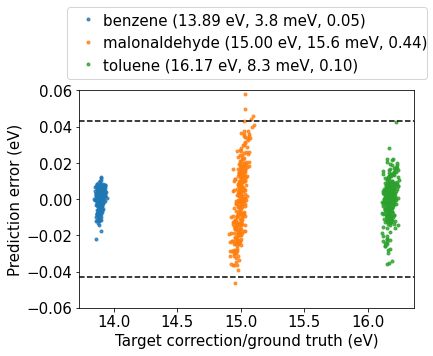

In [ ]:
break_points_0 = [0,601,300]
break_points_1 = [300,901,601]
mols = ['benzene', 'malonaldehyde', 'toluene']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.06,1.02,1.12,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/Chimela_BP.pdf", bbox_inches='tight')
plt.show()

In [ ]:
yTest_pred_Chimela = model_Chimela(xTest_Chimela).cpu().detach().numpy()
yTest_Chimela = yTest_Chimela.cpu().detach().numpy()

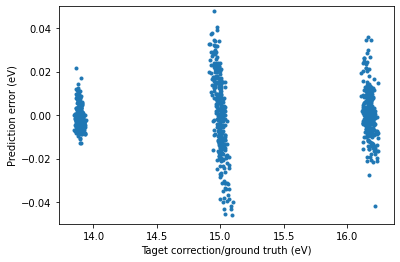

In [ ]:
plt.plot(yTest_Chimela, yTest_pred_Chimela-yTest_Chimela,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/Chimela_BP.pdf")
plt.show()

## ccpvtz experiment

In [ ]:
pvtzTr, pvtzTe = split_data(['methane', 'ethane', 'propane', 'butane', 'isobutane', 'water', 'ethanol', 'methanol'])
xTrain_pvtz = torch.tensor(pvtzTr[:, :-1]).to("cuda")
yTrain_pvtz = torch.tensor(pvtzTr[:, -1]).to("cuda")
xTest_pvtz = torch.tensor(pvtzTe[:, :-1]).to("cuda")
yTest_pvtz = torch.tensor(pvtzTe[:, -1]).to("cuda")
model_pvtz = BPNN().double()
model_pvtz.to("cuda")
Model_pvtz, loss_history = train_model(model_pvtz, xTrain_pvtz, 
                                        yTrain_pvtz, xTest_pvtz, yTest_pvtz, max_iter=100000, model_name=f"pvtz_data.pt")

epoch 1000, mae_train=0.13069932586129612, mae_valid=0.1267407576477662, % valid chemical accuracy=0.20190024375915527
epoch 2000, mae_train=0.07301992557300005, mae_valid=0.071029943369958, % valid chemical accuracy=0.45288994908332825
epoch 3000, mae_train=0.04131893896916185, mae_valid=0.04042379677836295, % valid chemical accuracy=0.7030878663063049
epoch 4000, mae_train=0.02991916281131835, mae_valid=0.029413786780634558, % valid chemical accuracy=0.8060173988342285
epoch 5000, mae_train=0.025682681502057988, mae_valid=0.025545321047198182, % valid chemical accuracy=0.8289785981178284
epoch 6000, mae_train=0.02261746428147027, mae_valid=0.0225553486869118, % valid chemical accuracy=0.8590657114982605
epoch 7000, mae_train=0.020515331194639472, mae_valid=0.020514843517806913, % valid chemical accuracy=0.8915281295776367
epoch 8000, mae_train=0.019027128941919606, mae_valid=0.01916096450687838, % valid chemical accuracy=0.906571626663208
epoch 9000, mae_train=0.017592974136623682, m

In [ ]:
pvtzTr, pvtzTe = split_data(['methane', 'ethane', 'propane', 'butane', 'isobutane', 'water', 'ethanol', 'methanol'])
best_model = torch.load("Models_BP/pvtz_data.pt")
yTe, yTe_pred = eavl_model(best_model, pvtzTe)

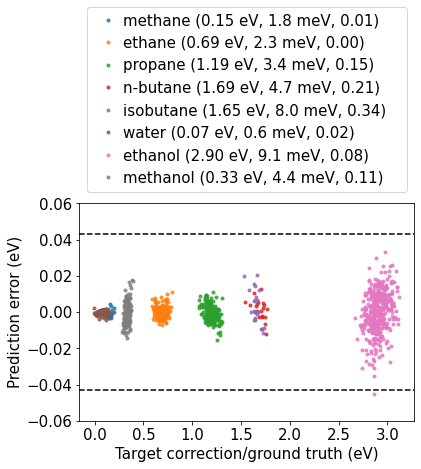

In [ ]:
break_points_0 = [0,21,221,421,442,463,663,1063]
break_points_1 = [21,221,421,442,463,663,1063,1263]
mols = ['methane', 'ethane', 'propane', 'n-butane', 'isobutane', 'water', 'ethanol', 'methanol']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/pvtz_BP.pdf", bbox_inches='tight')
plt.show()

In [ ]:
yTest_pred_pvtz = model_pvtz(xTest_pvtz).cpu().detach().numpy()
yTest_pvtz = yTest_pvtz.cpu().detach().numpy()

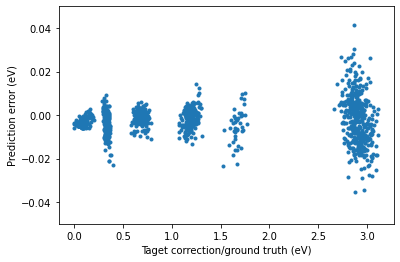

In [ ]:
plt.plot(yTest_pvtz, yTest_pred_pvtz-yTest_pvtz,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/pvtz_BP.pdf")
plt.show()

## ccpvdz experiment

In [ ]:
pvdzTr, pvdzTe = split_data(['benzene', 'toluene', 'malonaldehyde', 'ethanal', 'dimethylether'])
xTrain_pvdz = torch.tensor(pvdzTr[:, :-1]).to("cuda")
yTrain_pvdz = torch.tensor(pvdzTr[:, -1]).to("cuda")
xTest_pvdz = torch.tensor(pvdzTe[:, :-1]).to("cuda")
yTest_pvdz = torch.tensor(pvdzTe[:, -1]).to("cuda")
model_pvdz = BPNN().double()
model_pvdz.to("cuda")
Model_pvdz, loss_history = train_model(model_pvdz, xTrain_pvdz, 
                                        yTrain_pvdz, xTest_pvdz, yTest_pvdz, max_iter=100000, model_name=f"pvdz_data.pt")

epoch 1000, mae_train=1.6281672609719786, mae_valid=1.6285289075553784, % valid chemical accuracy=0.015372790396213531
epoch 2000, mae_train=0.4597205736356222, mae_valid=0.45360857780130437, % valid chemical accuracy=0.06225980073213577
epoch 3000, mae_train=0.28085136296324015, mae_valid=0.27778106272090713, % valid chemical accuracy=0.11683320254087448
epoch 4000, mae_train=0.20116545427985583, mae_valid=0.20187732292351426, % valid chemical accuracy=0.1944657862186432
epoch 5000, mae_train=0.18987903747802845, mae_valid=0.19064726706260127, % valid chemical accuracy=0.17678707838058472
epoch 6000, mae_train=0.19244410349543228, mae_valid=0.19334908674077128, % valid chemical accuracy=0.12298232316970825
epoch 7000, mae_train=0.19165879648197023, mae_valid=0.19277475445790052, % valid chemical accuracy=0.11145272850990295
epoch 8000, mae_train=0.18829200702204368, mae_valid=0.18935688955165117, % valid chemical accuracy=0.11683320254087448
epoch 9000, mae_train=0.1825337953265478, m

In [ ]:
pvdzTr, pvdzTe = split_data(['benzene', 'toluene', 'malonaldehyde', 'ethanal', 'dimethylether'])
best_model = torch.load("Models_BP/pvdz_data.pt")
yTe, yTe_pred = eavl_model(best_model, pvdzTe)

In [ ]:
yTe.shape

(1301,)

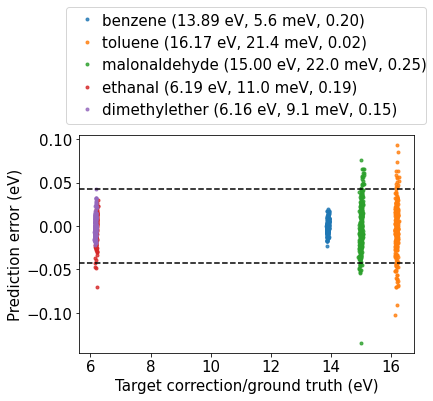

In [ ]:
break_points_0 = [0,300,601,901,1101]
break_points_1 = [300,601,901,1101,1301]
mols = ['benzene', 'toluene', 'malonaldehyde', 'ethanal', 'dimethylether']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
#plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.06,1.02,1.12,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/pvdz_BP.pdf", bbox_inches='tight')
plt.show()

In [ ]:
yTest_pred_pvdz = model_pvdz(xTest_pvdz).cpu().detach().numpy()
yTest_pvdz = yTest_pvdz.cpu().detach().numpy()

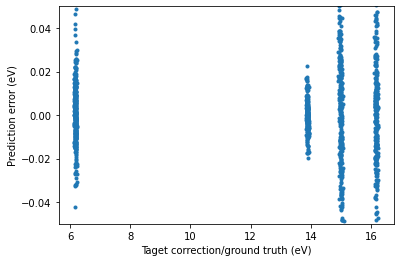

In [ ]:
plt.plot(yTest_pvdz, yTest_pred_pvdz-yTest_pvdz,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/pvdz_BP.pdf")
plt.show()

## transferability

In [ ]:
mepTr, mepTe = split_data(['methane', 'ethane', 'propane'])
xTrain_mep = torch.tensor(mepTr[:, :-1]).to("cuda")
yTrain_mep = torch.tensor(mepTr[:, -1]).to("cuda")
xTest_mep = torch.tensor(mepTe[:, :-1]).to("cuda")
yTest_mep = torch.tensor(mepTe[:, -1]).to("cuda")
model_mep = BPNN().double()
model_mep.to("cuda")
Model_mep, loss_history = train_model(model_mep, xTrain_mep, 
                                        yTrain_mep, xTest_mep, yTest_mep, max_iter=100000, model_name=f"mep_data.pt")

epoch 1000, mae_train=0.0259469099829698, mae_valid=0.025809335331293707, % valid chemical accuracy=0.8432304263114929
epoch 2000, mae_train=0.014717112303834424, mae_valid=0.01506868856379534, % valid chemical accuracy=0.9786223769187927
epoch 3000, mae_train=0.009313178899912454, mae_valid=0.009400575961518196, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.007719512711543997, mae_valid=0.007657666940551917, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.006021573836779926, mae_valid=0.005870745434185831, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.005231310532338016, mae_valid=0.005011151068628116, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.004879117745888223, mae_valid=0.0046394957665467675, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.004671708385854743, mae_valid=0.004475769865091516, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.00457007364474509, mae_valid=0.004384198946744464, % valid chemical accuracy=1.0
epoch 10000, mae_tr

In [ ]:
yTest_pred_mep = model_mep(xTest_mep).cpu().detach().numpy()
yTest_mep = yTest_mep.cpu().detach().numpy()

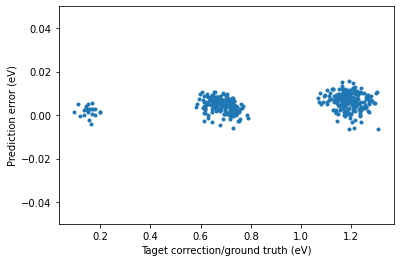

In [ ]:
plt.plot(yTest_mep, yTest_pred_mep-yTest_mep,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/methane_ethane_propane_BP.pdf")
plt.show()

### test on butane/isobutane

In [ ]:
biTr, biTe = split_data(['butane', 'isobutane'], ratio=1)
best_model = torch.load("Models_BP/mep_data.pt")
yTe, yTe_pred = eavl_model(best_model, biTr)

In [ ]:
yTe.shape

(202,)

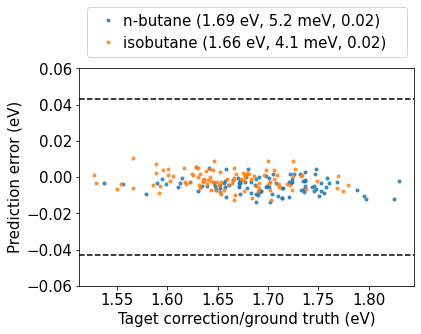

In [ ]:
break_points_0 = [0,101]
break_points_1 = [101,202]
mols = ['n-butane', 'isobutane']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/BP_transfer_butane_isobutane.pdf", bbox_inches='tight')
plt.show()

In [ ]:
biTr, biTe = split_data(['butane', 'isobutane'], ratio=1)
xTest_bi = torch.tensor(biTr[:,:-1]).to("cuda")
yTest_bi = torch.tensor(biTr[:,-1]).to("cuda")
yTest_pred_bi = model_mep(xTest_bi).cpu().detach().numpy()
yTest_bi = yTest_bi.cpu().detach().numpy()

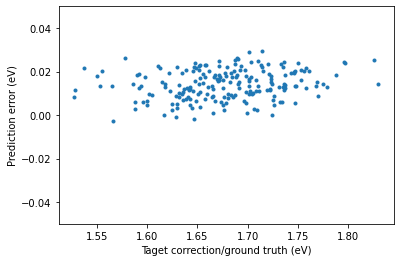

In [ ]:
plt.plot(yTest_bi, yTest_pred_bi-yTest_bi,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/BP_transfer_butane_isobutane.pdf")
plt.show()

In [ ]:
np.sum(np.abs(yTest_pred_bi-yTest_bi) < 0.043)

202

In [ ]:
202/len(yTest_bi)

1.0

In [ ]:
np.mean(np.abs(yTest_pred_bi-yTest_bi))

0.014181590267676347

### test on ethylene acetylene propene

In [ ]:
eapTr, eapTe = split_data(['ethylene', 'acetylene', 'propene'], ratio=1)
best_model = torch.load("Models_BP/mep_data.pt")
yTe, yTe_pred = eavl_model(best_model, eapTr)

In [ ]:
yTe.shape

(300,)

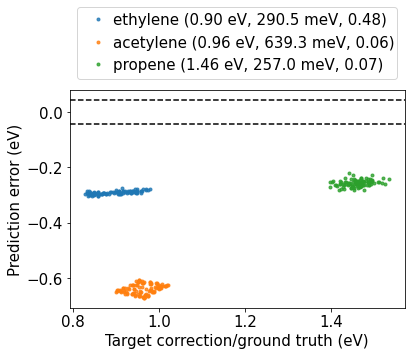

In [ ]:
break_points_0 = [0,100,200]
break_points_1 = [100,200,300]
mols = ['ethylene', 'acetylene', 'propene']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
#plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/BP_transfer_ethylene_acetylene_propene.pdf", bbox_inches='tight')
plt.show()

In [ ]:
eapTr, eapTe = split_data(['ethylene', 'acetylene', 'propene'], ratio=1)
xTest_eap = torch.tensor(eapTr[:,:-1]).to("cuda")
yTest_eap = torch.tensor(eapTr[:,-1]).to("cuda")
yTest_pred_eap = model_mep(xTest_eap).cpu().detach().numpy()
yTest_eap = yTest_eap.cpu().detach().numpy()

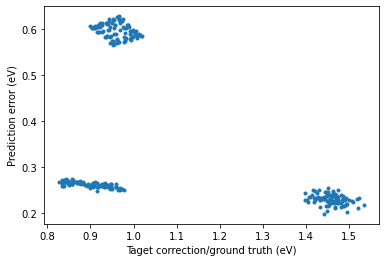

In [ ]:
plt.plot(yTest_eap, yTest_pred_eap-yTest_eap,'.')
#plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/BP_transfer_ethylene_acetylene_propene.pdf")
plt.show()

In [ ]:
np.mean(np.abs(yTest_pred_eap-yTest_eap))

0.3637510432317279

## methane alone

In [ ]:
ch4Tr, ch4Te = split_data(['methane'])
xTrain_ch4 = torch.tensor(ch4Tr[:, :-1]).to("cuda")
yTrain_ch4 = torch.tensor(ch4Tr[:, -1]).to("cuda")
xTest_ch4 = torch.tensor(ch4Te[:, :-1]).to("cuda")
yTest_ch4= torch.tensor(ch4Te[:, -1]).to("cuda")
model_ch4 = BPNN().double()
model_ch4.to("cuda")
Model_ch4, loss_history = train_model(model_ch4, xTrain_ch4, 
                                        yTrain_ch4, xTest_ch4, yTest_ch4, max_iter=100000, model_name=f"ch4_data.pt")

epoch 1000, mae_train=0.003103983370707692, mae_valid=0.0028166774699257256, % valid chemical accuracy=1.0
epoch 2000, mae_train=0.003089442552101574, mae_valid=0.0027842803471047643, % valid chemical accuracy=1.0
epoch 3000, mae_train=0.003072207032302384, mae_valid=0.0027392415565202486, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.003036438145377472, mae_valid=0.002684567082926552, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.002995115862926991, mae_valid=0.002641374193818631, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.0029248678192864944, mae_valid=0.0025709493884249874, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.0028216403448567038, mae_valid=0.002473081567029615, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.002673008305085649, mae_valid=0.002338355671630675, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.006515399993705462, mae_valid=0.006509390146768663, % valid chemical accuracy=1.0
epoch 10000, mae_train=0.002105042191983

In [ ]:
ch4Tr, ch4Te = split_data(['methane'])

In [ ]:
best_model = torch.load("Models_BP/ch4_data.pt")
yTe, yTe_pred = eavl_model(best_model, ch4Te)

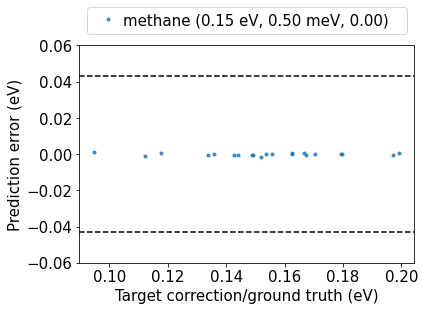

In [ ]:
break_points_0 = [0]
break_points_1 = [21]
mols = ['methane']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.2f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/BP_ch4.pdf", bbox_inches='tight')
plt.show()

In [ ]:
yTest_pred_ch4 = model_ch4(xTest_ch4).cpu().detach().numpy()
yTest_ch4 = yTest_ch4.cpu().detach().numpy()

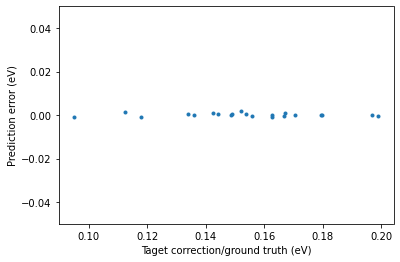

In [ ]:
plt.plot(yTest_ch4, yTest_pred_ch4-yTest_ch4,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/methane_BP.pdf")
plt.show()